### where I play with Karpathy's code

In [108]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt

In [141]:
class Tensor:
    
    #what tensors made this, from what operation, vis label?
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._prev = set(_children) 
        self._op = _op
        self.label = label
        self._backward = lambda : None #fills self.grad of own children, it knows the operator from which it came, and also knows the childrens through closure binding

    def __repr__(self): return f"Tensor(data={self.data})" 

    def __add__(self, other):
        other = other if isinstance(other, Tensor) else Tensor(other)
        out = Tensor(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out

    def __mul__(self, other): 
        other = other if isinstance(other, Tensor) else Tensor(other)
        out = Tensor(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out

    def __rmul__(self, other):
        return self * other
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only suppporting int/float powers"
        out = Tensor(self.data**other, (self,), f'**{other}')

        def __backward():
            self.grad += other * (self.data ** (other-1)) * out.grad
        out._backward = __backward

        return out
    
    def __truediv__(self, other): #self/other
        return self * other**-1
    
    def __neg__(self): #-self
        return self * -1
    
    def __sub__(self, other): #self-other
        return self + (-other)
    
    def __radd__(self, other): #other+self
        return self + other

    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
        out = Tensor(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1-t**2) * out.grad
        out._backward = _backward
        return out
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [52]:
a = Tensor(2.0, label='a')
b = Tensor(3.0, label='b')
c = Tensor(4.0, label='c')

d = a*b; d.label='d'
e = d+c; e.label='e'
L = e*d; L.label='L'

In [53]:
#vis

from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{%s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

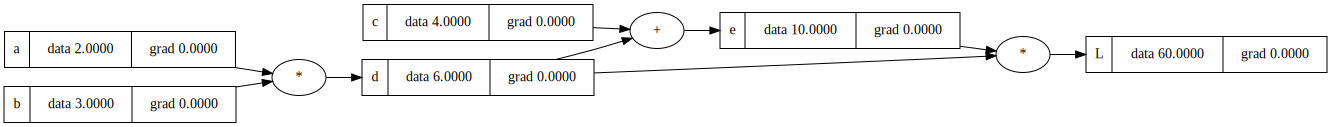

In [54]:
draw_dot(L)

In [55]:
def inline_grad():
    h = 0.0001

    a = Tensor(2.0, label='a')
    b = Tensor(3.0, label='b')
    c = Tensor(4.0, label='c')
    d = a*b; d.label='d'
    e = d+c; e.label='e'
    L = e*d; L.label='L'
    Ld = L.data

    a = Tensor(2.0, label='a');
    b = Tensor(3.0, label='b')
    c = Tensor(4.0, label='c')
    d = a*b; d.label='d'; d.data += h
    e = d+c; e.label='e'
    L = e*d; L.label='L'
    Lhd = L.data

    print((Lhd-Ld)/h)

inline_grad()


16.000099999970985


In [72]:
#inputs x1, x2
x1 = Tensor(2.0, label='x1')
x2 = Tensor(1.0, label='x2')
#weights w1, w2
w1 = Tensor(-1.0, label='w1')
w2 = Tensor(3.0, label='w2')
#bias of the neuron
b = Tensor(3.0, label='b')
#x1*w1+x2*w2+b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1+x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label='o'

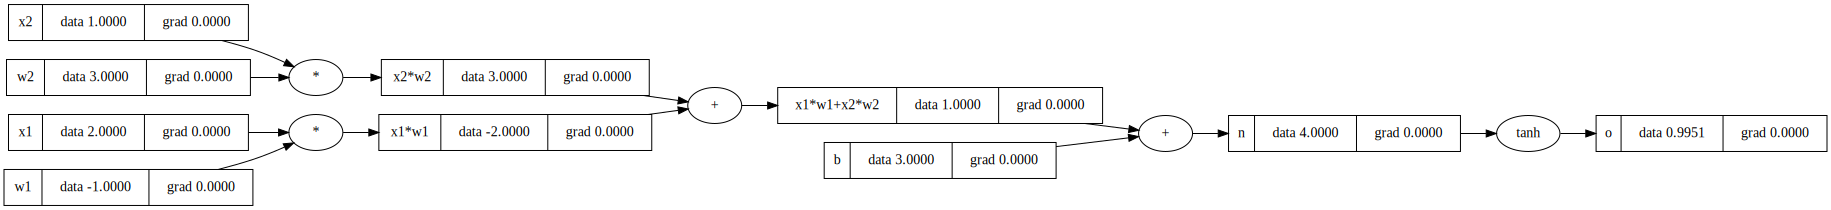

In [73]:
draw_dot(o)

In [74]:
o.backward()

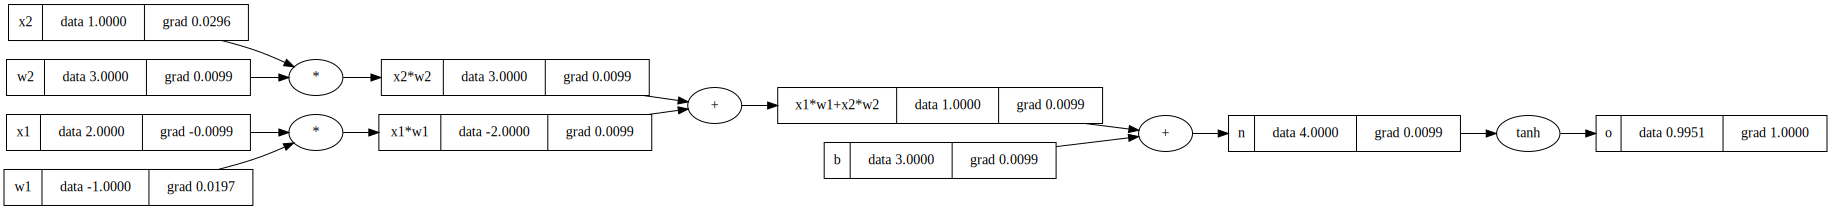

In [75]:
draw_dot(o)

In [57]:
o.grad = 1.0

In [68]:
o._backward()
o.grad, n.grad

(1.0, 0.009866037165440211)

In [61]:
n._backward()
n.grad, b.grad, x1w1x2w2.grad

(0.009866037165440211, 0.009866037165440211, 0.009866037165440211)

In [62]:
b._backward() #does absolutely nothing

In [63]:
x1w1x2w2._backward()
x1w1.grad, x2w2.grad

(0.009866037165440211, 0.009866037165440211)

In [65]:
x1w1._backward()
x1.grad, w1.grad

(-0.009866037165440211, 0.019732074330880423)

In [67]:
x2w2._backward()
x2.grad, w2.grad

(0.029598111496320634, 0.009866037165440211)

In [81]:
#what bro? this does not work; because we are replacing gradients (so we need to add them)
a = Tensor(3.0, label='a')
b = a + a; b.label='b'

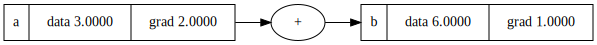

In [84]:
draw_dot(b)

In [83]:
b.backward()

In [106]:
#after implementing other auxillary expression;
a = Tensor(2.0)
b = Tensor(3.0)

In [107]:
-a/b**2

Tensor(data=-0.2222222222222222)

In [178]:
class Neuron:
    def __init__(self, nin):
        self.w = [Tensor(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Tensor(random.uniform(-1,1))

    def __call__(self, x):
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]
    
class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons] 
        return outs[0] if len(outs) == 1 else outs #why make a list for a single element?
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

    
class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [179]:
n = Neuron(2)
n([1,2])
n([1,2,3]) #clips the zip

Tensor(data=-0.3979425607619838)

In [180]:
l = Layer(2, 3)
l([1,2])

[Tensor(data=-0.975058759724223),
 Tensor(data=0.9002864971367962),
 Tensor(data=0.715009494502336)]

In [214]:
mlp = MLP(3, [4, 4, 1])
mlp([1,2,3,4])

Tensor(data=-0.415702872563051)

In [215]:
mlp.parameters(), len(mlp.parameters())

([Tensor(data=0.4573858351383606),
  Tensor(data=0.6946340392362997),
  Tensor(data=-0.15082173184387693),
  Tensor(data=0.6531431100151994),
  Tensor(data=0.27098758628165776),
  Tensor(data=-0.17541773488294132),
  Tensor(data=0.8450707407918836),
  Tensor(data=0.48961030492194424),
  Tensor(data=0.5957513406695296),
  Tensor(data=0.019315411061083587),
  Tensor(data=0.4510313809614952),
  Tensor(data=0.4674816800852879),
  Tensor(data=-0.040035725263966704),
  Tensor(data=-0.05327820887636303),
  Tensor(data=0.20967285698038696),
  Tensor(data=-0.13674479890958913),
  Tensor(data=0.45925771636566726),
  Tensor(data=-0.07462284100093108),
  Tensor(data=0.756598156811132),
  Tensor(data=0.6086422340232369),
  Tensor(data=0.8006372594778228),
  Tensor(data=0.5055320996495205),
  Tensor(data=0.941546405711436),
  Tensor(data=-0.25297563760954955),
  Tensor(data=0.4267410434674215),
  Tensor(data=0.4641803211405602),
  Tensor(data=0.7308998337019528),
  Tensor(data=-0.13517288131961824),

In [216]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]

ys = [1.0, -1.0, -1.0, 1.0] #desired targets

In [241]:
epochs = 20

for e in range(epochs):
    #forward
    ypred = [mlp(x) for x in xs]
    loss = sum((yout-ygt)**2 for ygt, yout in zip(ys, ypred)) #this is also a Tensor now?

    #backward
    for p in mlp.parameters():
        p.grad = 0
    loss.backward()

    #update
    for p in mlp.parameters():
        p.data += -0.01*p.grad
    
    print(e, loss.data)

0 0.017987979897377073
1 0.017908765299959287
2 0.01783021140087617
3 0.017752310163216642
4 0.017675053678009683
5 0.017598434161713875
6 0.017522443953765572
7 0.01744707551418387
8 0.017372321421231032
9 0.017298174369126375
10 0.017224627165813227
11 0.017151672730776342
12 0.017079304092909354
13 0.017007514388430345
14 0.01693629685884512
15 0.016865644848955346
16 0.01679555180491244
17 0.016726011272314316
18 0.016657016894344887
19 0.016588562409954516


In [242]:
ypred

[Tensor(data=0.947034957984086),
 Tensor(data=-0.945604308341216),
 Tensor(data=-0.9299106539083979),
 Tensor(data=0.9231113855787406)]